In [8]:
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten # type: ignore
from tensorflow.keras.models import Sequential # type: ignore

In [9]:
tf.__version__

'2.18.0'

## Preprocessing

In [10]:
train_datagen= ImageDataGenerator(rescale = 1./255,
                                 rotation_range=30,
                                 shear_range = 0.4,
                                 zoom_range = 0.4,
                                 horizontal_flip = True)
training_set = train_datagen.flow_from_directory('./data/Training',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3087 images belonging to 7 classes.


In [11]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow_from_directory('./data/Testing',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
validation_set=test_datagen.flow_from_directory('./data/Validation',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


## Visualizations

{'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}


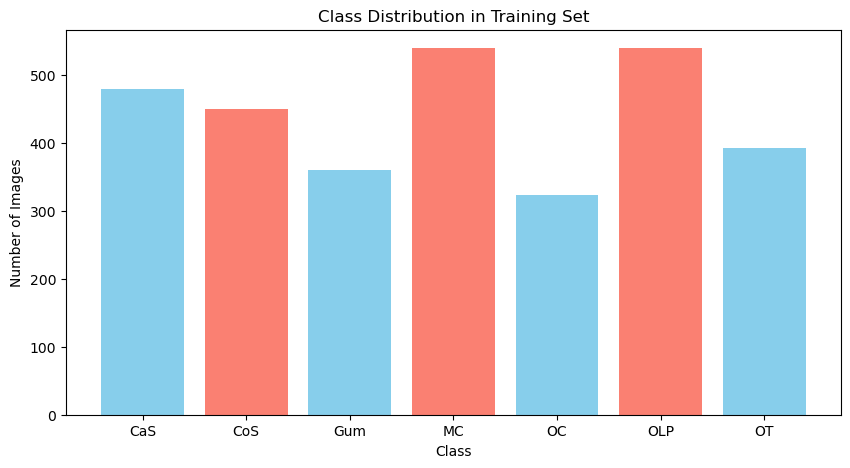

In [12]:
#Visualize the distribution of the classes to understand the balance of the dataset.
import os
import matplotlib.pyplot as plt
import seaborn as sns
train_dir='./data/Training'
class_counts={}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path): #if it is an existing floder
         count = len([
            img for img in os.listdir(class_path)
            if img.lower().endswith(('.jpg'))
        ])
    class_counts[class_name] = count
print(class_counts)
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')


plt.show()

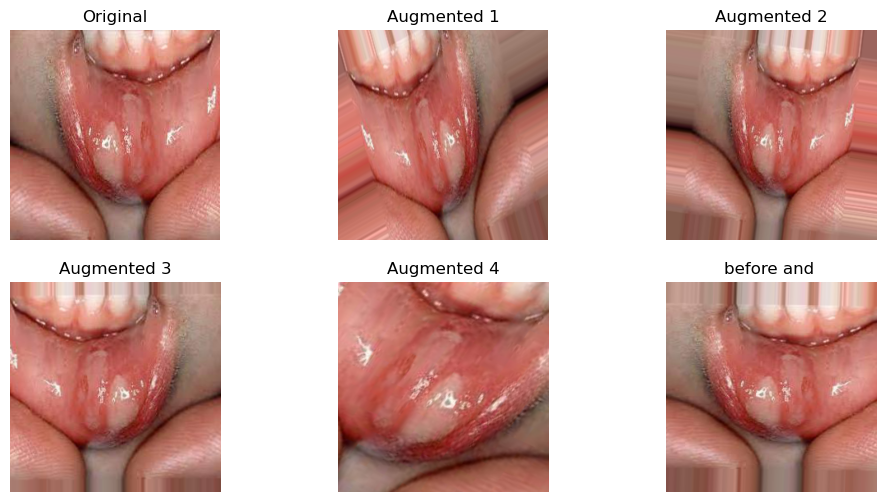

In [13]:
# image example before and after augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array # type: ignore
import numpy as np
img=load_img('./data/Training/CaS/a_79.jpg')
img_array=img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

augment_gen=ImageDataGenerator(#rescale = 1./255,
                                rotation_range=30,
                                   shear_range = 0.4,
                                   zoom_range = 0.4,
                                   horizontal_flip = True)
#generate augmented images
aug_iter = augment_gen.flow(img_array, batch_size=1)


plt.figure(figsize=(12, 6))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Augmented images
for i in range(5):
    aug_img = next(aug_iter)[0].astype('uint8') #iterate to next batch and convert it to presntable form
    plt.subplot(2, 3, i+2) #start from second place   
    plt.imshow(aug_img)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')
plt.title("before and ")
plt.show()

## Building the model

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.1745 - loss: 1.9659 - val_accuracy: 0.2374 - val_loss: 1.8807
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.2320 - loss: 1.8728 - val_accuracy: 0.2432 - val_loss: 1.8429
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.2833 - loss: 1.7886 - val_accuracy: 0.3774 - val_loss: 1.6866
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.3328 - loss: 1.6759 - val_accuracy: 0.4105 - val_loss: 1.5821
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.3779 - loss: 1.5946 - val_accuracy: 0.4737 - val_loss: 1.4366
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.3927 - loss: 1.5385 - val_accuracy: 0.4348 - val_loss: 1.5174
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.4306 - loss: 1.4797 - val_accuracy: 0.5117 - val_loss: 1.3571
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.4562 - loss: 1.4246 - val_accu

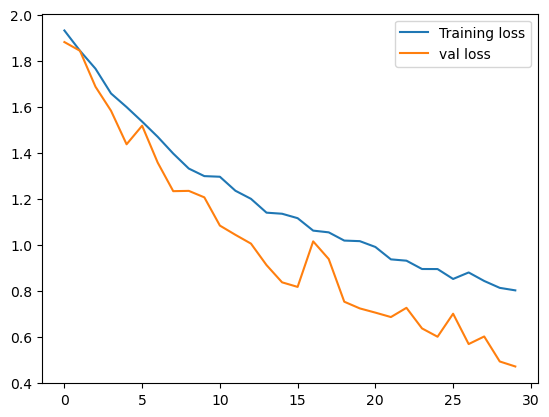

In [18]:
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.5),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  
])
early_stopping=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)#early stopping for validation loss

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    training_set,
    epochs=30,
    
    validation_data=validation_set,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
plt.plot(history.history["loss"],label="Training loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.legend()
plt.show()